In [11]:
import cv2
import os

video_path = '/content/videoplayback.mp4'
output_dir = 'frames'
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f"{output_dir}/frame_{frame_count:04d}.png", frame)
    frame_count += 1

cap.release()


In [12]:
from skimage import io, img_as_float, restoration
from skimage.filters import median
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
import numpy as np

def evaluate_denoising(original, noisy, denoised):
    psnr = peak_signal_noise_ratio(original, denoised)
    ssim = structural_similarity(original, denoised, channel_axis=-1)
    mse = mean_squared_error(original, denoised)
    return psnr, ssim, mse

def apply_denoising(image_path):
    original = img_as_float(io.imread(image_path))
    noisy = original + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=original.shape)
    noisy = np.clip(noisy, 0, 1)

    median_img = median(noisy, disk(3))
    wavelet_img = restoration.denoise_wavelet(noisy, multichannel=True)

    return original, noisy, median_img, wavelet_img


In [14]:
!pip install n2v csbdeep

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6

In [19]:
import n2v
print(n2v.__version__)


0.3.3


In [20]:
pip install -U n2v


In [28]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.6 MB/s eta 0:00:00


Median PSNR: 22.5481
Median SSIM: 0.7262
Median MSE: 0.005561

Wavelet PSNR: 26.0710
Wavelet SSIM: 0.6744
Wavelet MSE: 0.002471



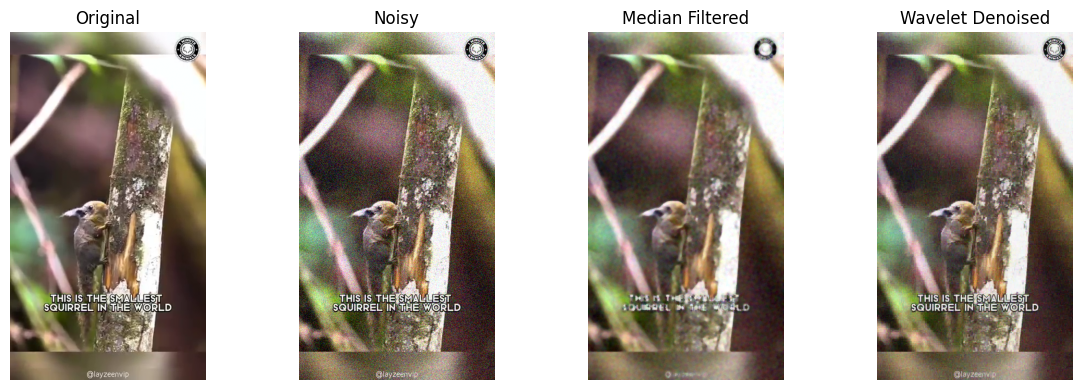

In [29]:
from skimage import io, img_as_float, restoration
from skimage.filters import median
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------ Denoising + Metrics Functions ------------------------

def evaluate_denoising(original, denoised, label):
    psnr = peak_signal_noise_ratio(original, denoised, data_range=1.0)
    ssim = structural_similarity(original, denoised, channel_axis=-1, data_range=1.0)
    mse = mean_squared_error(original, denoised)
    print(f"{label} PSNR: {psnr:.4f}")
    print(f"{label} SSIM: {ssim:.4f}")
    print(f"{label} MSE: {mse:.6f}\n")


def apply_denoising(image_path):
    original = img_as_float(io.imread(image_path))
    noisy = original + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=original.shape)
    noisy = np.clip(noisy, 0, 1)

    # Apply median filter to each channel separately
    median_channels = [median(noisy[:, :, i], disk(3)) for i in range(noisy.shape[2])]
    median_img = np.stack(median_channels, axis=2)

    # Wavelet Denoising
    wavelet_img = restoration.denoise_wavelet(noisy, channel_axis=-1, rescale_sigma=True)

    return original, noisy, median_img, wavelet_img


# ------------------------ Run on an Image ------------------------

# Provide a valid image path here
image_path = '/content/frames/frame_0021.png'  # or any valid image path

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found: {image_path}")

original, noisy, median_img, wavelet_img = apply_denoising(image_path)

# ------------------------ Evaluate Denoising ------------------------

evaluate_denoising(original, median_img, "Median")
evaluate_denoising(original, wavelet_img, "Wavelet")

# ------------------------ Optional: Visualization ------------------------

titles = ['Original', 'Noisy', 'Median Filtered', 'Wavelet Denoised']
images = [original, noisy, median_img, wavelet_img]

plt.figure(figsize=(12, 4))
for i, img in enumerate(images):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.clip(img, 0, 1))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
def process_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 100, 200)
    inverted = cv2.bitwise_not(gray)
    return thresh, blurred, edges, inverted


In [31]:
input_path = '/content/videoplayback.mp4'
cap = cv2.VideoCapture(input_path)
width, height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_thresh = cv2.VideoWriter('video_thresh.mp4', fourcc, fps, (width, height), False)
out_blur = cv2.VideoWriter('video_blur.mp4', fourcc, fps, (width, height), False)
out_edges = cv2.VideoWriter('video_edges.mp4', fourcc, fps, (width, height), False)
out_invert = cv2.VideoWriter('video_invert.mp4', fourcc, fps, (width, height), False)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    t, b, e, i = process_frame(frame)
    out_thresh.write(t)
    out_blur.write(b)
    out_edges.write(e)
    out_invert.write(i)

cap.release()
out_thresh.release()
out_blur.release()
out_edges.release()
out_invert.release()


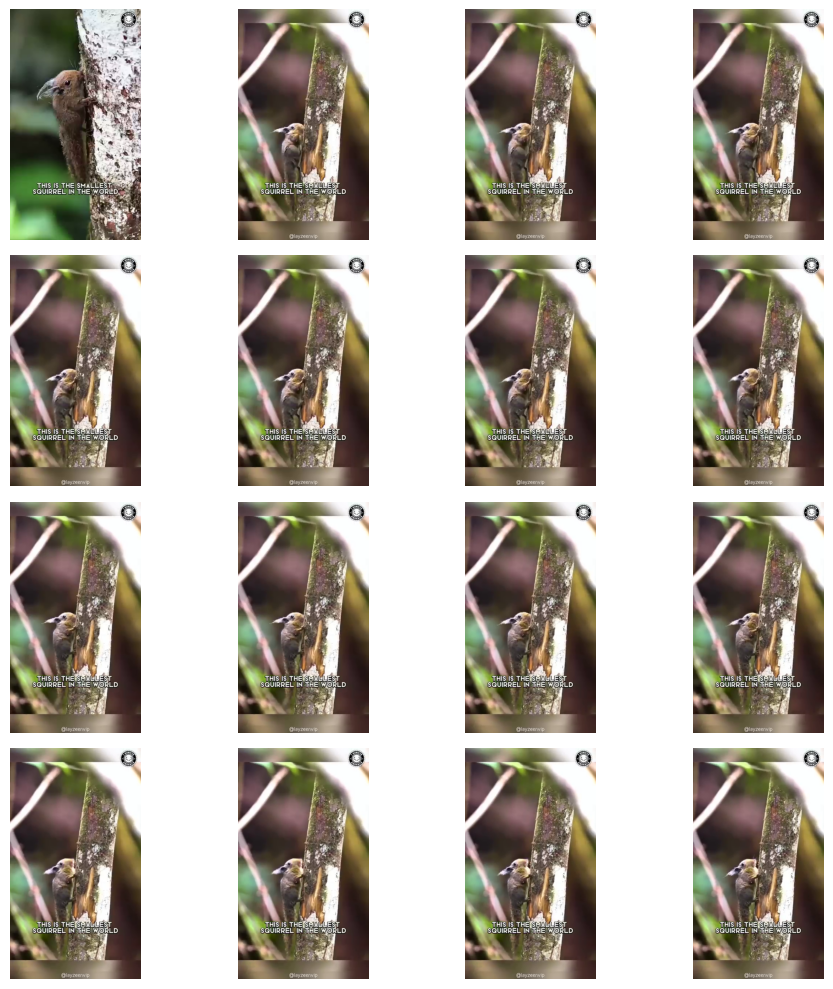

In [32]:
import glob
import matplotlib.pyplot as plt

frame_files = sorted(glob.glob("frames/*.png"))[:16]  # Select 16 for 4x4
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, file in zip(axes.flatten(), frame_files):
    img = cv2.imread(file)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.savefig("frame_collage.png")


In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pypiahmad/realistic-action-recognition-ucf50-dataset")

print("Path to dataset files:", path)

100%|██████████| 0.98G/0.98G [00:09<00:00, 107MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pypiahmad/realistic-action-recognition-ucf50-dataset/versions/1


In [39]:
import kagglehub
import os

# Step 1: Download the dataset
path = kagglehub.dataset_download("pevogam/ucf101")

# Step 2: Explore the downloaded files and directories
print("Base download path:", path)
print("\nContents of the downloaded path:")
print(os.listdir(path))

# Step 3: Search for the UCF101 video classes
for root, dirs, files in os.walk(path):
    print(f"\nFound directory: {root}")
    for d in dirs:
        print("  └──", d)
    break  # only print the first level


Base download path: /kaggle/input/ucf101

Contents of the downloaded path:
['UCF101', 'UCF101TrainTestSplits-RecognitionTask']

Found directory: /kaggle/input/ucf101
  └── UCF101
  └── UCF101TrainTestSplits-RecognitionTask


In [40]:
import os

root_dir = "/kaggle/input/ucf101/UCF101"
for root, dirs, files in os.walk(root_dir):
    print("Directory:", root)
    for d in dirs:
        print("  Subfolder:", d)
    for f in files[:3]:  # print only a few files for brevity
        print("  File:", f)
    print("-" * 40)


Directory: /kaggle/input/ucf101/UCF101
  Subfolder: UCF-101
----------------------------------------
Directory: /kaggle/input/ucf101/UCF101/UCF-101
  Subfolder: HorseRace
  Subfolder: StillRings
  Subfolder: ApplyLipstick
  Subfolder: HammerThrow
  Subfolder: VolleyballSpiking
  Subfolder: Biking
  Subfolder: PlayingCello
  Subfolder: BodyWeightSquats
  Subfolder: TaiChi
  Subfolder: Punch
  Subfolder: BreastStroke
  Subfolder: Billiards
  Subfolder: BoxingPunchingBag
  Subfolder: BasketballDunk
  Subfolder: PoleVault
  Subfolder: ThrowDiscus
  Subfolder: BaseballPitch
  Subfolder: Knitting
  Subfolder: SumoWrestling
  Subfolder: HorseRiding
  Subfolder: Mixing
  Subfolder: BrushingTeeth
  Subfolder: HighJump
  Subfolder: Skijet
  Subfolder: SkateBoarding
  Subfolder: MilitaryParade
  Subfolder: IceDancing
  Subfolder: CricketShot
  Subfolder: Fencing
  Subfolder: JugglingBalls
  Subfolder: Swing
  Subfolder: RockClimbingIndoor
  Subfolder: PlayingFlute
  Subfolder: SalsaSpin
  Subfold

In [41]:
import os
import shutil
import random

# Define source and destination directories
SOURCE_DIR = '/kaggle/input/ucf101/UCF101/UCF-101'
DEST_DIR = '/kaggle/working/UCF101_subset'

# List of selected classes (can be updated as needed)
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

# Create the destination directory if it doesn't exist
os.makedirs(DEST_DIR, exist_ok=True)

# Iterate over the selected classes and copy videos
for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)

    # Create class folder in destination
    os.makedirs(dest_class_path, exist_ok=True)

    # Select random 10 videos from the class
    selected = random.sample(os.listdir(class_path), VIDEOS_PER_CLASS)

    # Copy selected videos to the destination
    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print(f"Subset created at: {DEST_DIR}")


Subset created at: /kaggle/working/UCF101_subset


In [42]:
import cv2
import os
import numpy as np

# Define parameters
FRAME_RATE = 5  # Extract every 5th frame
RESIZE_DIM = (112, 112)  # Resize frames to 112x112
MAX_FRAMES = 16  # Number of frames per video

# Function to extract frames from video
def extract_frames(video_path, max_frames=MAX_FRAMES, frame_rate=FRAME_RATE, resize_dim=RESIZE_DIM):
    # Read the video
    cap = cv2.VideoCapture(video_path)

    frames = []
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Extract every 'frame_rate'-th frame
        if frame_count % frame_rate == 0:
            frame_resized = cv2.resize(frame, resize_dim)
            frames.append(frame_resized)

        frame_count += 1

        # Stop once we have extracted enough frames
        if len(frames) == max_frames:
            break

    cap.release()

    # If fewer than MAX_FRAMES are extracted, pad the sequence with the last frame
    while len(frames) < max_frames:
        frames.append(frames[-1])

    return np.array(frames)

# Process each class and video
video_frames = {}
for cls in SELECTED_CLASSES:
    class_path = os.path.join(DEST_DIR, cls)
    video_frames[cls] = []

    for video in os.listdir(class_path):
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path)
        video_frames[cls].append(frames)

print("Frame extraction completed.")


Frame extraction completed.


In [43]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the selected classes
labels = label_encoder.fit_transform(SELECTED_CLASSES)

# Create a dictionary to map class names to labels
class_labels = dict(zip(SELECTED_CLASSES, labels))
print("Label encoding completed.")


Label encoding completed.


In [44]:
from sklearn.model_selection import train_test_split

# Prepare data and labels
data = []
labels = []

# Add frames and their corresponding labels
for cls in SELECTED_CLASSES:
    for frames in video_frames[cls]:
        data.append(frames)
        labels.append(class_labels[cls])

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (40, 16, 112, 112, 3)
Testing data shape: (10, 16, 112, 112, 3)


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define 3D CNN Model
def create_3d_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # 3D convolution layers with padding='same'
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Define input shape based on frame size and sequence length
input_shape = (MAX_FRAMES, RESIZE_DIM[0], RESIZE_DIM[1], 3)  # (16, 112, 112, 3) for 16 frames of 112x112 images with 3 color channels
num_classes = len(SELECTED_CLASSES)

# Create the model
model = create_3d_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 56, 56, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 56, 56, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,702,597 (25.57 MB)

 Trainable params: 6,702,597 (25.57 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

# Save the model
model.save("/kaggle/working/ucf101_3dcnn_model.h5")

print("Training completed and model saved.")


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.1898 - loss: 327.5409 - val_accuracy: 0.3000 - val_loss: 6.0150
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.2739 - loss: 5.4794 - val_accuracy: 0.1000 - val_loss: 2.4024
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.4137 - loss: 1.6058 - val_accuracy: 0.2000 - val_loss: 3.1761
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.6988 - loss: 1.0494 - val_accuracy: 0.2000 - val_loss: 6.9783
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.6595 - loss: 1.0199 - val_accuracy: 0.2000 - val_loss: 8.4268
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.6482 - loss: 0.8318 - val_accuracy: 0.3000 - val_loss: 9.5388
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.7716 - loss: 0.4595 - val_accuracy: 0.5000 - val_loss: 9.5163
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.8244 - loss: 0.3942 - val_accuracy: 0.5000 - val_los

Training completed and model saved.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Classification Report:
               precision    recall  f1-score   support

       Biking       0.00      0.00      0.00         3
PlayingGuitar       0.00      0.00      0.00         2
       Typing       0.33      0.50      0.40         2
     JumpRope       0.50      1.00      0.67         3

     accuracy                           0.40        10
    macro avg       0.21      0.38      0.27        10
 weighted avg       0.22      0.40      0.28        10

Unique classes in y_test: [1 2 3 4]
Unique classes in y_pred_classes: [2 3 4]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


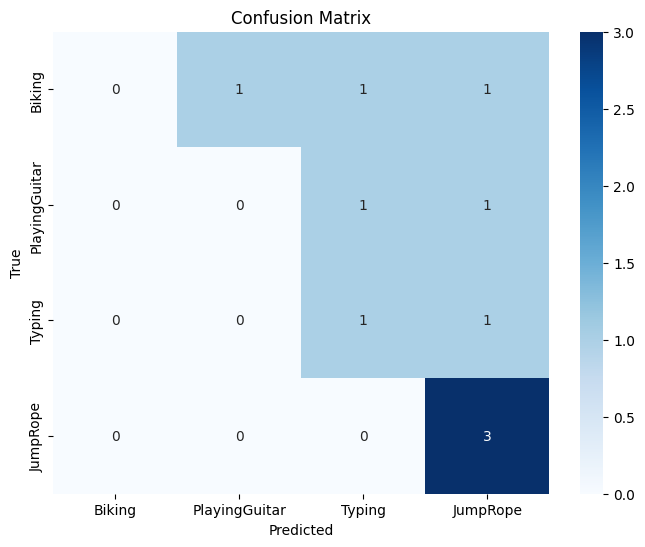

In [48]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes in y_test and y_pred_classes
unique_classes_test = np.unique(y_test)
unique_classes_pred = np.unique(y_pred_classes)

# Get the target names for the present classes in y_test
present_classes = [SELECTED_CLASSES[i] for i in unique_classes_test]

# Print classification report using present classes
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=present_classes))

# Print unique classes found in y_test and y_pred_classes for diagnostics
print(f"Unique classes in y_test: {unique_classes_test}")
print(f"Unique classes in y_pred_classes: {unique_classes_pred}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=unique_classes_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_classes, yticklabels=present_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()